In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import optuna
import warnings

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Distances

In [2]:
def CosineSimilarity(a, b):
    return (a * b).sum() / ( np.sqrt((a ** 2).sum()) * np.sqrt((b ** 2).sum()) )
    
def CosineDistance(a, b):
    return 1 - CosineSimilarity(a, b)

In [3]:
def MinkowskiDistance(a, b, p):
    return (np.power(np.abs(a - b), p).sum()) ** (1 / p)
    
def ManhattanDistance(a, b):
    return MinkowskiDistance(a, b, 1)

def EuclideanDistance(a, b):
    return MinkowskiDistance(a, b, 2)
    
def ChebyshevDistance(a, b):
    return np.abs(a - b).max()

In [4]:
def TestDistProperties(dist):
    a = np.array([1, 2])
    b = np.array([3, 4])
    c = np.array([5, 7])
    print(f"""{dist.__name__}:
    {dist.__name__} symmetry: 
        {dist(a, b)} = {dist(b, a)} 
    {dist.__name__} triangle inequality: 
        {dist(a, c)} <= {dist(a, b) + dist(b, c)}
    {dist.__name__} identity:
        {dist(a, a)} = 0""")

In [5]:
TestDistProperties(CosineDistance)
TestDistProperties(ManhattanDistance)
TestDistProperties(EuclideanDistance)
TestDistProperties(ChebyshevDistance)

CosineDistance:
    CosineDistance symmetry: 
        0.01613008990009257 = 0.01613008990009257 
    CosineDistance triangle inequality: 
        0.012237034670931068 <= 0.016400396703246778
    CosineDistance identity:
        2.220446049250313e-16 = 0
ManhattanDistance:
    ManhattanDistance symmetry: 
        4.0 = 4.0 
    ManhattanDistance triangle inequality: 
        9.0 <= 9.0
    ManhattanDistance identity:
        0.0 = 0
EuclideanDistance:
    EuclideanDistance symmetry: 
        2.8284271247461903 = 2.8284271247461903 
    EuclideanDistance triangle inequality: 
        6.4031242374328485 <= 6.433978400210179
    EuclideanDistance identity:
        0.0 = 0
ChebyshevDistance:
    ChebyshevDistance symmetry: 
        2 = 2 
    ChebyshevDistance triangle inequality: 
        5 <= 5
    ChebyshevDistance identity:
        0 = 0


## Kernels

In [6]:
# abs can be omitted since we will pass only distances in kernel, 
# which non-negative (see triangle inequality)
def UniformKernel(u):
    return 1/2 * (u < 1)

def GeneralizedKernel(u, a, b):
    return (1 - np.abs(u) ** a) ** b * (u < 1)

def TriangularKernel(u):
    return GeneralizedKernel(u, 1, 1)

def EpanechnikovKernel(u):
    return 3 / 4 * (1 - u ** 2) * (u < 1)

def GaussianKernel(u):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-(u ** 2) / 2)

kernels = [UniformKernel, TriangularKernel, EpanechnikovKernel, GaussianKernel]

In [7]:
import scipy.integrate as integrate

def TestKernelProperties(kern):
    print(f"{kern.__name__} integral: {integrate.quad(kern, np.NINF, np.PINF)}")

In [8]:
TestKernelProperties(UniformKernel)
TestKernelProperties(TriangularKernel)
TestKernelProperties(EpanechnikovKernel)
TestKernelProperties(GaussianKernel)

UniformKernel integral: (0.0, 4.547473508869945e-13)
TriangularKernel integral: (-0.999999944138475, 0.0004272645085346971)
EpanechnikovKernel integral: (-9.103678867918502e+20, 1.7957356920899402e+21)
GaussianKernel integral: (0.9999999999999997, 1.017819145094224e-08)


/tmp/ipykernel_20203/3478044690.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  print(f"{kern.__name__} integral: {integrate.quad(kern, np.NINF, np.PINF)}")
/tmp/ipykernel_20203/3478044690.py:4: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  print(f"{kern.__name__} integral: {integrate.quad(kern, np.NINF, np.PINF)}")


# Model Implementation

In [9]:
class KNN:
    def __init__(self, param, FixedWindow, metric=EuclideanDistance, kernel=GaussianKernel, _IsLowess=False):
        self._param = param
        self._fixedWindow = FixedWindow
        self._lowess = _IsLowess
        if _IsLowess:
            self._param += 1
        self._kernel = kernel
        self._nearest = NearestNeighbors(algorithm='auto', metric=metric)
        
    def fit(self, X, Y):
        self._nearest.fit(X)
        self._trainTarget = Y
        self._Xshape = X.shape

    @staticmethod
    def argmax(x, y):
        dist_accum = {}
        for dist, val in zip(x, y):
            was = dist_accum.get(val, 0)
            dist_accum[val] = was + dist
        value = max(dist_accum, key=dist_accum.get, default=None)
        return value

    def __predict_fixed(self, X, weights):
        dists, ind = self._nearest.radius_neighbors(X, radius=self._param)
        h = self._param
        if self._lowess:
            dists = dists[:,1:]
            ind = ind[:,1:]
        for i in range(len(dists)):
            dists[i] /= h
        target = []
        _weights = []
        for i in range(len(ind)):
            target.append([])
            _weights.append([])
            for j in range(len(ind[i])):
                target[i].append(self._trainTarget[ind[i][j]])
                _weights[i].append(weights[ind[i][j]])
        return dists, target, _weights, h

    def __predict_nonfixed(self, X, weights):
        dists, ind = self._nearest.kneighbors(X, n_neighbors=self._param + 1)
        h = dists[:, -1]
        dists = dists[:,:-1] # remove last column = h            
        ind = ind[:,:-1] 
        if self._lowess:
            dists = dists[:,1:]
            ind = ind[:,1:]
        target = self._trainTarget[ind]
        for i in range(dists.shape[-1]):
            dists[:, i] /= h
        # print(ind)
        _weights = weights[ind]
        return dists, target, _weights, h

    def __inner_predict(self, X, weights):
        if weights is None:
            weights = np.array([1] * self._Xshape[0])
        if self._fixedWindow:
            dists, target, weights, h = self.__predict_fixed(X, weights)
        else: 
            dists, target, weights, h = self.__predict_nonfixed(X, weights)
        kern_dists = [self._kernel(dist) for dist in dists]
        kern_dists = [dist * np.array(w) for dist, w in zip(kern_dists, weights)]
        return kern_dists, target
    
    def prob_class(self, x, y, weights=None):
        kern_dists, target = self.__inner_predict([x], weights)
        kern_dists = kern_dists[0]
        target = target[0]
        dist_accum = {}
        dist_sum = 0
        for dist, val in zip(kern_dists, target):
            was = dist_accum.get(val, 0)
            dist_accum[val] = was + dist
            dist_sum += dist
        dist_accum = {k: v / dist_sum for k, v in dist_accum.items()}
        # print(dist_accum)
        return dist_accum.get(y, 0)

    def predict(self, X, weights=None):
        kern_dists, target = self.__inner_predict(X, weights)
        return list(map(lambda t: self.argmax(t[0], t[1]), zip(kern_dists, target)))

In [10]:
testEnv = KNN(3, False)
trainX = np.array([[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6]])
trainY = np.array(["a", "b", "a", "b"])
testEnv.fit(trainX, trainY)
testX = np.array([[6, 7, 4], [4, 5, 5]])
print(testEnv.predict(testX, weights=np.array([2, 1., 1., 1.])))

['b', 'b']


In [11]:
testEnv.prob_class([1, 2, 3], "b")

0.34439893189914644

# Dataset

In [12]:
df_unprocessed = pd.read_csv("hearts.csv")
df_unprocessed.groupby("target").size()
df_unprocessed.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


<Axes: >

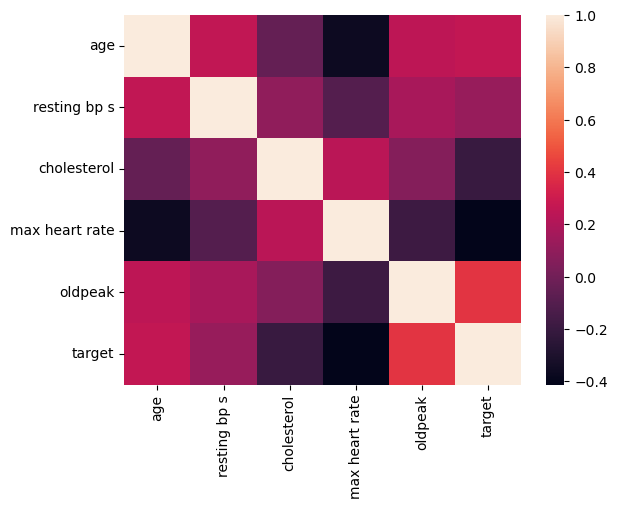

In [13]:
df = df_unprocessed.drop(columns=['sex', 'chest pain type', 'fasting blood sugar', 'ST slope', 'exercise angina', 'resting ecg'])

sns.heatmap(df.corr())

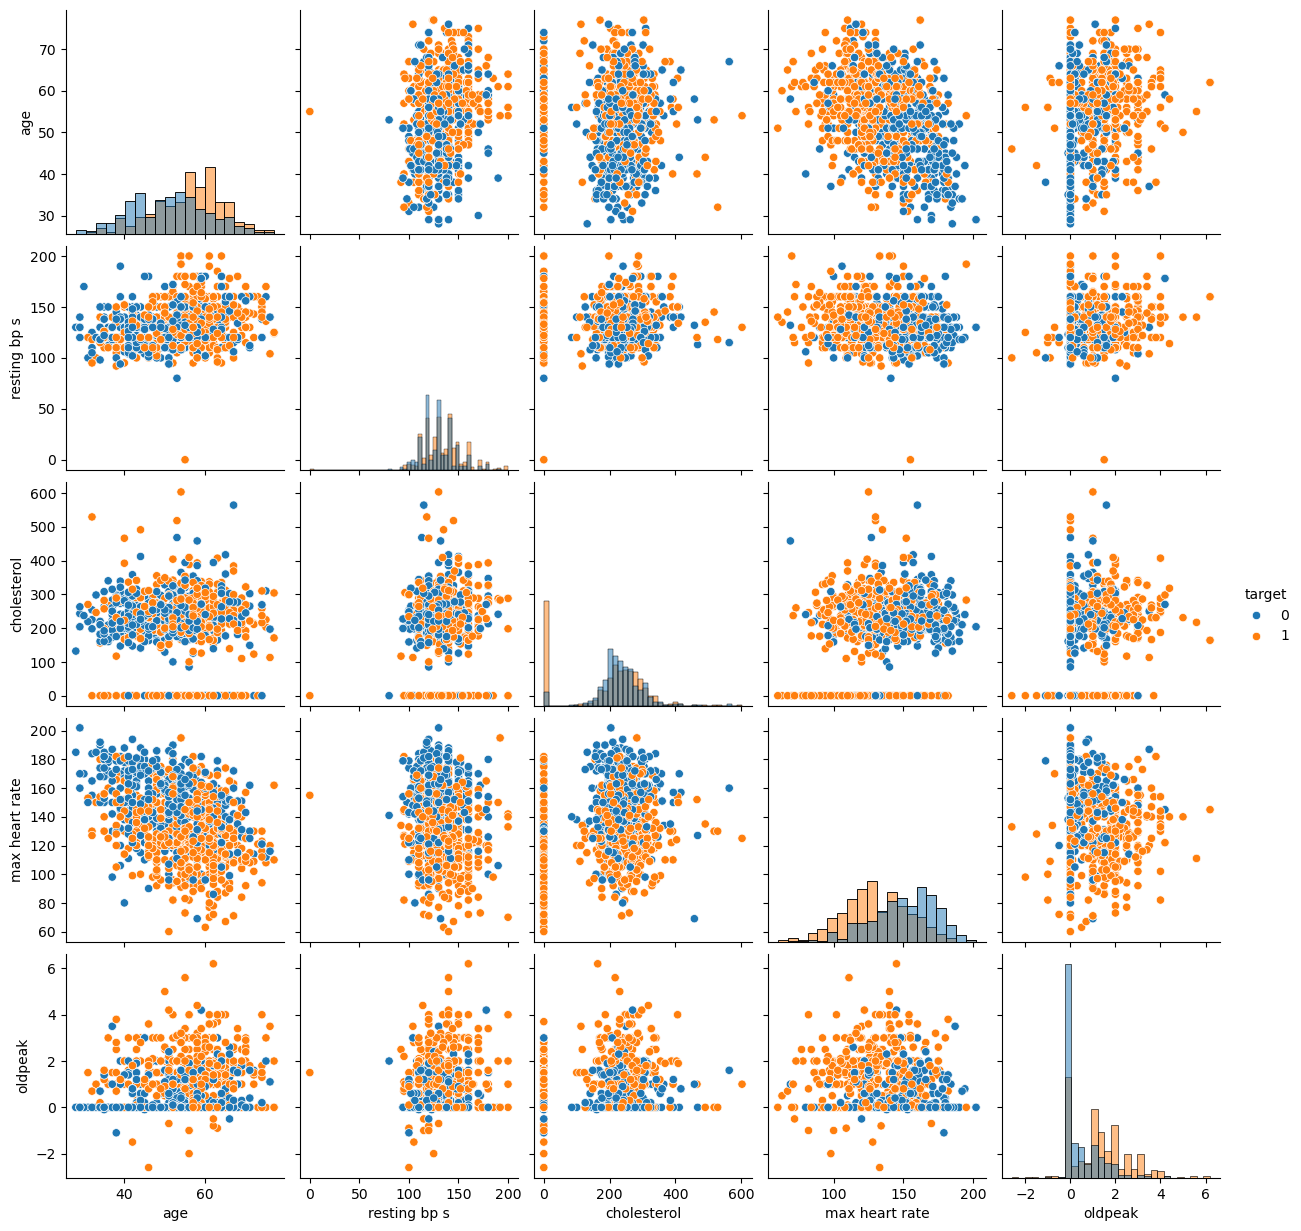

In [14]:
sns.pairplot(df, diag_kind='hist', hue='target')

In [15]:
scaler = StandardScaler()
y = df['target'].to_numpy()
X = scaler.fit_transform(df.drop(columns=['target']))
X

array([[-1.46672783,  0.42732826,  0.7756736 ,  1.26503857, -0.84979236],
       [-0.50460037,  1.51658739, -0.29951178,  0.63775761,  0.07111913],
       [-1.78743698, -0.11730131,  0.71648908, -1.63613587, -0.84979236],
       ...,
       [ 0.35062404, -0.11730131, -0.782852  , -0.96964985,  0.25530143],
       [ 0.35062404, -0.11730131,  0.25287704,  1.34344869, -0.84979236],
       [-1.68053393,  0.31840234, -0.34883221,  1.30424363, -0.84979236]])

In [16]:
trainX, testX, trainY, testY = train_test_split(X, y, random_state=42, test_size=0.2)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, random_state=42, test_size=0.2)

## sklearn implementation

In [17]:
%%time 
skNeigh = KNeighborsClassifier(n_neighbors=3, metric=ManhattanDistance)
skNeigh.fit(trainX, trainY)
f1_score(testY, skNeigh.predict(testX))

CPU times: user 900 ms, sys: 0 ns, total: 900 ms
Wall time: 899 ms


0.7906976744186046

## my implementation

In [18]:
%%time
myNeigh = KNN(3, False)
myNeigh.fit(trainX, trainY)
f1_score(testY, myNeigh.predict(testX))

CPU times: user 961 ms, sys: 3.19 ms, total: 965 ms
Wall time: 961 ms


0.7751937984496124

# Hyperparameter Optimization

In [19]:
def plotN(init, title):
    val_values = []
    test_values = []
    for neighbors in range(1, 25):
        neigh = init(neighbors)
        # neigh = KNeighborsClassifier(n_neighbors=neighbors, metric=EuclideanDistance)
        neigh.fit(trainX, trainY)
        f1_val = f1_score(valY, neigh.predict(valX))
        f1_test = f1_score(testY, neigh.predict(testX))
        val_values.append(f1_val)
        test_values.append(f1_test)
    plt.plot(range(1, 25), val_values, label='validate')
    plt.plot(range(1, 25), test_values, label='test')
    plt.xlabel("n_neighbors")
    plt.ylabel("f1 score")
    plt.title(title)
    plt.legend()
    plt.show()

## sklearn implementation

In [20]:
def scObjective(trial):
    metrics = trial.suggest_categorical('metric', 
                                        [ManhattanDistance, EuclideanDistance,
                                        ChebyshevDistance, CosineDistance])    
    neighbors = trial.suggest_int('n_neighbors', 1, 25)
    neigh = KNeighborsClassifier(n_neighbors=neighbors, metric=metrics)
    neigh.fit(trainX, trainY)
    f1 = f1_score(valY, neigh.predict(valX))
    return f1

In [21]:
scstudy = optuna.create_study(direction='maximize')
warnings.filterwarnings('ignore')
scstudy.optimize(scObjective, n_trials=100)

[I 2024-05-13 13:27:51,729] A new study created in memory with name: no-name-7ba2ef1d-b41d-4c31-881c-bc533b79fe65
[I 2024-05-13 13:27:52,478] Trial 0 finished with value: 0.7570621468926554 and parameters: {'metric': <function EuclideanDistance at 0x71c1e5ec4360>, 'n_neighbors': 7}. Best is trial 0 with value: 0.7570621468926554.
[I 2024-05-13 13:27:53,180] Trial 1 finished with value: 0.7337278106508875 and parameters: {'metric': <function ManhattanDistance at 0x71c2090871a0>, 'n_neighbors': 10}. Best is trial 0 with value: 0.7570621468926554.
[I 2024-05-13 13:27:53,801] Trial 2 finished with value: 0.7727272727272727 and parameters: {'metric': <function CosineDistance at 0x71c1e5ec4180>, 'n_neighbors': 20}. Best is trial 2 with value: 0.7727272727272727.
[I 2024-05-13 13:27:54,568] Trial 3 finished with value: 0.7441860465116279 and parameters: {'metric': <function EuclideanDistance at 0x71c1e5ec4360>, 'n_neighbors': 15}. Best is trial 2 with value: 0.7727272727272727.
[I 2024-05-13 

In [22]:
o_metric = scstudy.best_params['metric']
o_neighbors = scstudy.best_params['n_neighbors']
print(o_metric, o_neighbors)
neigh = KNeighborsClassifier(n_neighbors=o_neighbors, metric=o_metric)
neigh.fit(trainX, trainY)
f1 = f1_score(testY, neigh.predict(testX))
f1

<function ManhattanDistance at 0x71c2090871a0> 1


0.796812749003984

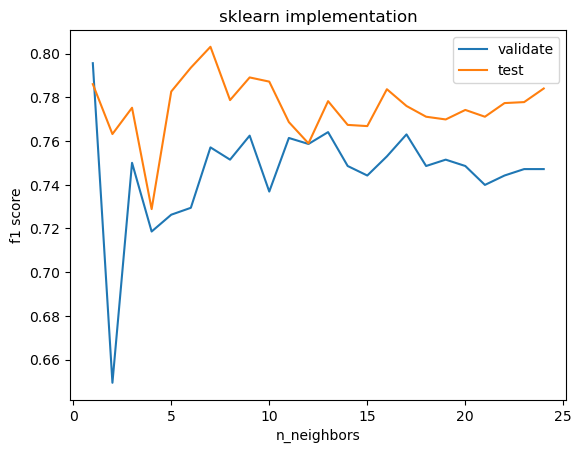

In [23]:
plotN(lambda n: KNeighborsClassifier(n_neighbors=n, metric=EuclideanDistance), "sklearn implementation")

## my implementation

In [24]:
def myObjective(trial):
    metrics = trial.suggest_categorical('metric', 
                                        [ManhattanDistance, EuclideanDistance,
                                        ChebyshevDistance, CosineDistance])    
    kernel = trial.suggest_categorical('kernel', [UniformKernel, TriangularKernel,
                                        EpanechnikovKernel, GaussianKernel])
    neighbors = trial.suggest_int('n_neighbors', 1, 25)
    neigh = KNN(param=neighbors, FixedWindow=False, metric=metrics, kernel=kernel)
    neigh.fit(trainX, trainY)
    f1 = f1_score(valY, neigh.predict(valX))
    return f1

In [25]:
mystudy = optuna.create_study(direction='maximize')
mystudy.optimize(myObjective, n_trials=100)

[I 2024-05-13 13:29:33,930] A new study created in memory with name: no-name-0941d833-17fe-48a6-abcb-dff44d8b826a
[I 2024-05-13 13:29:34,473] Trial 0 finished with value: 0.7849462365591398 and parameters: {'metric': <function CosineDistance at 0x71c1e5ec4180>, 'kernel': <function TriangularKernel at 0x71c1e5ec5080>, 'n_neighbors': 1}. Best is trial 0 with value: 0.7849462365591398.
[I 2024-05-13 13:29:35,285] Trial 1 finished with value: 0.7868852459016393 and parameters: {'metric': <function ManhattanDistance at 0x71c2090871a0>, 'kernel': <function UniformKernel at 0x71c1e5ec4e00>, 'n_neighbors': 6}. Best is trial 1 with value: 0.7868852459016393.
[I 2024-05-13 13:29:36,076] Trial 2 finished with value: 0.7752808988764045 and parameters: {'metric': <function EuclideanDistance at 0x71c1e5ec4360>, 'kernel': <function UniformKernel at 0x71c1e5ec4e00>, 'n_neighbors': 12}. Best is trial 1 with value: 0.7868852459016393.
[I 2024-05-13 13:29:36,781] Trial 3 finished with value: 0.7630057803

In [26]:
o_metric = mystudy.best_params['metric']
o_neighbors = mystudy.best_params['n_neighbors']
o_kernel = mystudy.best_params['kernel']
print(o_metric, o_neighbors, o_kernel)
neigh = KNN(param=o_neighbors, FixedWindow=False, metric=o_metric, kernel=o_kernel)
neigh.fit(trainX, trainY)
f1 = f1_score(testY, neigh.predict(testX))
f1

<function EuclideanDistance at 0x71c1e5ec4360> 8 <function TriangularKernel at 0x71c1e5ec5080>


0.8379446640316206

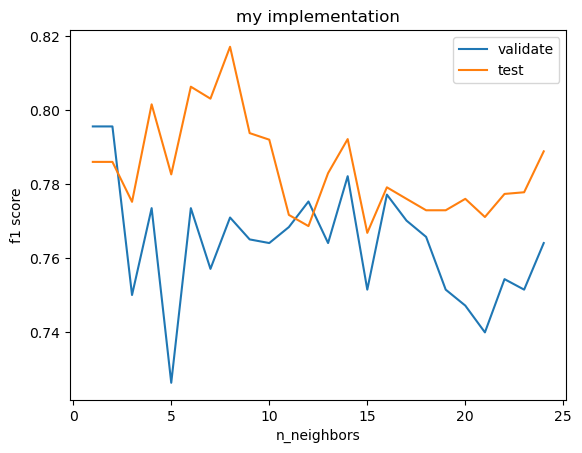

In [27]:
plotN(lambda n: KNN(param=n, FixedWindow=False, metric=EuclideanDistance, kernel=GaussianKernel), "my implementation")

# Lowess

In [28]:
def lowess(k, trainX, trainY, metric=EuclideanDistance, kernel=GaussianKernel, LowessKernel=GaussianKernel):
    neigh = KNN(param=k+1, FixedWindow=False, metric=metric, kernel=kernel, _IsLowess=True)
    neigh.fit(trainX, trainY)
    weights = []
    for x, y in zip(trainX, trainY):
        weights.append(LowessKernel(neigh.prob_class(x, y)))
    return np.array(weights)

In [29]:
lowess_weights = lowess(3, trainX, trainY)

In [30]:
k = 3
for lowess_kernel in kernels:
    neigh = KNN(k, False)
    neigh.fit(trainX, trainY)
    weights = lowess(k, trainX, trainY, LowessKernel=lowess_kernel)
    print(f"{lowess_kernel} -- valid:\n"
    f"\twithout lowess: {f1_score(valY, neigh.predict(valX))}\n"
    f"\twith lowess: {f1_score(valY, neigh.predict(valX, weights))}\n"
    f"{lowess_kernel} -- test:\n"
    f"\twithout lowess: {f1_score(testY, neigh.predict(testX))}\n"
    f"\twith lowess: {f1_score(testY, neigh.predict(testX, weights))}\n"
    )

<function UniformKernel at 0x71c1e5ec4e00> -- valid:
	without lowess: 0.75
	with lowess: 0.7540983606557377
<function UniformKernel at 0x71c1e5ec4e00> -- test:
	without lowess: 0.7751937984496124
	with lowess: 0.75

<function TriangularKernel at 0x71c1e5ec5080> -- valid:
	without lowess: 0.75
	with lowess: 0.7039106145251397
<function TriangularKernel at 0x71c1e5ec5080> -- test:
	without lowess: 0.7751937984496124
	with lowess: 0.7209302325581395

<function EpanechnikovKernel at 0x71c1e5ec5120> -- valid:
	without lowess: 0.75
	with lowess: 0.7039106145251397
<function EpanechnikovKernel at 0x71c1e5ec5120> -- test:
	without lowess: 0.7751937984496124
	with lowess: 0.7421875

<function GaussianKernel at 0x71c1e5ec51c0> -- valid:
	without lowess: 0.75
	with lowess: 0.7582417582417582
<function GaussianKernel at 0x71c1e5ec51c0> -- test:
	without lowess: 0.7751937984496124
	with lowess: 0.7876447876447876



In [31]:
def sampled(X, Y, SampleRate, k, metric=EuclideanDistance, kernel=GaussianKernel, SampleKernel=GaussianKernel):
    newX = []
    newY = []
    neigh = KNN(param=k+1, FixedWindow=False, metric=metric, kernel=kernel, _IsLowess=True)
    neigh.fit(trainX, trainY)
    weights = []
    for x, y in zip(trainX, trainY):
        w = SampleKernel(neigh.prob_class(x, y))
        if w > SampleRate:
            newX.append(x)
            newY.append(y)
    return np.array(newX), np.array(newY)

In [32]:
k = 3
for sample_kernel in kernels:
    sampledTrainX, sampledTrainY = sampled(trainX, trainY, SampleRate=0.15, k=3, SampleKernel=sample_kernel)
    neigh = KNeighborsClassifier(n_neighbors=k, metric=EuclideanDistance)
    neigh.fit(sampledTrainX, sampledTrainY)
    print(f"{lowess_kernel} -- valid:\n"
    f"\twithout lowess: {f1_score(valY, neigh.predict(valX))}\n"
    f"\twith lowess: {f1_score(valY, neigh.predict(valX))}\n"
    f"{lowess_kernel} -- test:\n"
    f"\twithout lowess: {f1_score(testY, neigh.predict(testX))}\n"
    f"\twith lowess: {f1_score(testY, neigh.predict(testX))}\n"
    )

<function GaussianKernel at 0x71c1e5ec51c0> -- valid:
	without lowess: 0.6629213483146067
	with lowess: 0.6629213483146067
<function GaussianKernel at 0x71c1e5ec51c0> -- test:
	without lowess: 0.7250996015936255
	with lowess: 0.7250996015936255

<function GaussianKernel at 0x71c1e5ec51c0> -- valid:
	without lowess: 0.6629213483146067
	with lowess: 0.6629213483146067
<function GaussianKernel at 0x71c1e5ec51c0> -- test:
	without lowess: 0.7250996015936255
	with lowess: 0.7250996015936255

<function GaussianKernel at 0x71c1e5ec51c0> -- valid:
	without lowess: 0.6629213483146067
	with lowess: 0.6629213483146067
<function GaussianKernel at 0x71c1e5ec51c0> -- test:
	without lowess: 0.7250996015936255
	with lowess: 0.7250996015936255

<function GaussianKernel at 0x71c1e5ec51c0> -- valid:
	without lowess: 0.75
	with lowess: 0.75
<function GaussianKernel at 0x71c1e5ec51c0> -- test:
	without lowess: 0.7751937984496124
	with lowess: 0.7751937984496124

